In [60]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt

from tools import create_x_y

In [61]:
df = pd.read_csv('../datasets/binned/tsla_binned.csv')

In [3]:
df.columns

Index(['date_', 'ticker', 'open', 'high', 'low', 'close', 'vol', 'max_comp',
       'max_neg', 'max_neu', 'max_pos', 'min_comp', 'min_neg', 'min_neu',
       'min_pos', 'std_comp', 'std_neg', 'std_neu', 'std_pos', 'mean_comp',
       'mean_neg', 'mean_neu', 'mean_pos', 'median_comp', 'median_neg',
       'median_neu', 'median_pos', 'count', 'diffs', 'bin_2', 'bin_3',
       'bin_5'],
      dtype='object')

In [65]:
VITAL_COLS = ["date_", "ticker", "bin_2", "diffs", "bin_5"]
OTHER_COLS = [i for i in df.columns if i not in VITAL_COLS]
print(OTHER_COLS)


def encode_y(y):
    if len(set(y)) == 2:
        remap_dict = {-1: 0, 1: 1}
    elif len(set(y)) == 3:
        remap_dict = {-1: 0, 0: 1, 1: 2}
    elif len(set(y)) == 5:
        remap_dict = {-2: 0, -1: 1, 0: 2, 1: 3, 2: 4}
    for i, val in enumerate(y):
        y[i] = remap_dict[val]

    return y


def weight_data(x):
    # least represented class is 1.0, others are percentage_least/percentage_other
    percentages = {}
    len_x = len(x)
    for uniq_val in set(x):
        percentages[uniq_val] = sum([1 for i in x if i == uniq_val]) / len_x
    least = min(percentages, key=percentages.get)
    weights = {i: percentages[least] / percentages[i] for i in percentages}
    return weights


# match feature importances from vector with multiple lagged vals of each column
def importances_from_lag(x, col_names):
    lag = int(len(x) / len(col_names))
    len_col = len(col_names)
    imp = {
        col_names[i]: sum(x[i * lag : (i + 1) * lag]) / lag
        for i in range(len_col)
    }

    return imp

def save_importances_plot(fi, name, title):
    import seaborn as sns
    importances = importances_from_lag(fi, OTHER_COLS) 
    x_axis = list(importances.keys())
    y_axis = [float(i) for i in importances.values()]
    figure = plt.gcf()
    figure.set_size_inches(9, 6)
    sns.barplot(y=x_axis, x=y_axis).set_title(title)
    
    plt.savefig(f'../plots/{name}.pdf')

['open', 'high', 'low', 'close', 'vol', 'max_comp', 'max_neg', 'max_neu', 'max_pos', 'min_comp', 'min_neg', 'min_neu', 'min_pos', 'std_comp', 'std_neg', 'std_neu', 'std_pos', 'mean_comp', 'mean_neg', 'mean_neu', 'mean_pos', 'median_comp', 'median_neg', 'median_neu', 'median_pos', 'count', 'bin_3']


In [5]:
def measure_acc(x, y, binary=True):
    mode = "binary:logistic"
    if not binary:
        mode = "multi:softprob"
    clf = xgb.XGBClassifier(objective=mode, random_state=42)#, sample_weight=compute_sample_weight(weight_data(y), y))

    params = {
        "colsample_bytree": uniform(0.7, 0.3),
        "gamma": uniform(0, 0.5),
        "learning_rate": uniform(0.003, 0.3),  # default 0.1
        "max_depth": randint(2, 6),  # default 3
        "n_estimators": randint(100, 400),  # default 100
        "subsample": uniform(0.6, 0.4), 
    }
    time_split = TimeSeriesSplit(n_splits=5)
    xgb_search = RandomizedSearchCV(
        clf,
        param_distributions=params,
        random_state=42,
        n_iter=20,
        cv=time_split,
        verbose=1,
        n_jobs=4,
    )
    split = int(0.8 * len(x))
    xgb_search.fit(x[:split], y[:split])
    y_pred = xgb_search.predict(x[split:])
    cm = confusion_matrix(y[split:], y_pred)
    acc = sum(y_pred == y[split:]) / len(y_pred)
    fi = xgb_search.best_estimator_.feature_importances_

    return cm, acc, fi

In [7]:
cm = {}
acc = {}
fi = {}
for lag in [3, 6, 10, 16]:
    x, y = create_x_y(df, x_cols=OTHER_COLS, y_col="bin_3", lag=lag)
    y = encode_y(y)
    cm[lag], acc[lag], fi[lag] = measure_acc(x, y, binary=False)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [8]:
## baseline
split = int(0.8 * len(x))
zeroes = pd.Series([0 for _ in range(len(y[split:]))])
acc_base = sum(zeroes == y[split:]) / len(y[split:])
print(acc_base)

0.22325581395348837


In [63]:
print(cm)

{3: array([[ 40, 276,  70],
       [ 53, 806,  76],
       [ 39, 262, 100]], dtype=int64), 6: array([[ 31, 273,  82],
       [ 39, 819,  77],
       [ 34, 276,  91]], dtype=int64), 10: array([[ 26, 282,  77],
       [ 30, 847,  58],
       [ 25, 280,  96]], dtype=int64), 16: array([[ 36, 285,  63],
       [ 28, 851,  56],
       [ 31, 280,  90]], dtype=int64)}


In [24]:
print(len(fi[3])/len(OTHER_COLS), )

3.0


In [15]:
print(fi[3])

[0.01559905 0.01444146 0.02012096 0.01752292 0.01544419 0.01608634
 0.02057325 0.02107208 0.01710633 0.01942277 0.02062706 0.01878646
 0.0137252  0.0161375  0.0412848  0.01179052 0.01229652 0.01231336
 0.01134711 0.01170105 0.01246658 0.         0.01109028 0.01093124
 0.01160029 0.01196008 0.01318889 0.011834   0.01111528 0.01118876
 0.         0.         0.         0.01150678 0.01130794 0.01128461
 0.         0.         0.         0.01166135 0.01191878 0.01182685
 0.01227821 0.01231332 0.01287066 0.01209182 0.01248995 0.01254595
 0.01220816 0.01223294 0.01279788 0.01124191 0.01241391 0.01155631
 0.01268148 0.01199261 0.01655793 0.0115405  0.01150191 0.01127654
 0.01299985 0.0119849  0.01179527 0.01138054 0.01157985 0.01093201
 0.01057309 0.01182263 0.01240933 0.01165539 0.01064772 0.0119646
 0.01255451 0.01129435 0.01211718 0.01147883 0.01228717 0.01434377
 0.01103953 0.01543908 0.01482783]


In [62]:
print(acc)

0.22325581395348837


In [34]:
importances_from_lag(fi[6], OTHER_COLS)

{'open': 0.008031166701888045,
 'high': 0.00935576002423962,
 'low': 0.009954791671286026,
 'close': 0.009231553257753452,
 'vol': 0.010719255854686102,
 'max_comp': 0.0060755598824471235,
 'max_neg': 0.00576949732688566,
 'max_neu': 0.0004044093657284975,
 'max_pos': 0.006157684760789077,
 'min_comp': 0.00608836323954165,
 'min_neg': 0.0,
 'min_neu': 0.005987720175956686,
 'min_pos': 0.0,
 'std_comp': 0.006322903170560797,
 'std_neg': 0.006373546086251736,
 'std_neu': 0.00626105706517895,
 'std_pos': 0.006493933964520693,
 'mean_comp': 0.006042857887223363,
 'mean_neg': 0.00677074515260756,
 'mean_neu': 0.006093229089553158,
 'mean_pos': 0.00624677228430907,
 'median_comp': 0.006285761715844274,
 'median_neg': 0.005854027151751022,
 'median_neu': 0.00631610699929297,
 'median_pos': 0.006179604058464368,
 'count': 0.00648069327386717,
 'bin_3': 0.007169659327094753}

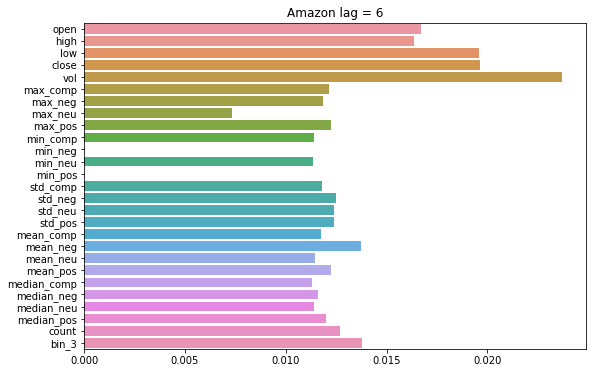

In [66]:
for i in [3, 6, 10, 16]:
    save_importances_plot(fi[i], f'xgb_amzn_imp_{i}', f'Amazon lag = {i}')
